In [1]:
import numpy as np
import pandas as pd
import joblib # Para guardar modelo

# Datos
from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    RepeatedStratifiedKFold
)

# MODELO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Lambda, Layer, Maximum
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (Precision, Recall, AUC, CategoricalAccuracy)

import tensorflow as tf

from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical

# EVALUACION
from sklearn.metrics import (
    roc_auc_score as roc_auc, 
    precision_score as precision,  
    f1_score as f1, 
    recall_score as recall,
    accuracy_score as accuracy, 
    fbeta_score as fbeta,
    make_scorer,
    classification_report
)
from scipy.stats import ks_2samp

# OPTIMIZACION
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

tf.random.set_seed(33)

# Modelado

In [2]:
# Definicion de modelo LSTM base

METRICAS = [
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    # Mean(name='mean'),
    # Accuracy(name='accuracy')
    CategoricalAccuracy(name='cat_acc'),
    # ks_stat,
    # f2,
    # f05
]

esLoss = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30, min_delta=0, restore_best_weights=True)

def build_model(neurons_input=128, activation_='tanh', learning_rate_=0.001):
    # global base_model_LSTM

    model = Sequential()    
    model.add(GRU(neurons_input, input_shape=(30,266), return_sequences=True, activation=activation_))
    # model.add(GRU(128, input_shape=(10,130), return_sequences=True, activation=activation_))
    model.add(GRU(neurons_input, return_sequences=False, activation=activation_))
    model.add(Dense(64, activation=activation_))
    model.add(Dense(32, activation=activation_))
    model.add(Dense(np.array(le.classes_).shape[0], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate_)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICAS)

    # print(base_model_LSTM.summary())
    return model

def build_model_for_optimization(neurons_input=128, activation='tanh', learning_rate=0.001):
    # global model_LSTM_opt

    model = Sequential()    
    model.add(GRU(neurons_input, input_shape=(30,266), return_sequences=True, activation=activation))
    # model.add(GRU(128, input_shape=(10,130), return_sequences=True, activation=activation))
    model.add(GRU(neurons_input, return_sequences=False, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(np.array(le.classes_).shape[0], activation='softmax'))
    
    # LO QUE PROBÉ para optimizar con randomizedSearch
    # model.add(tf.keras.layers.Softmax())
    # model.add(argmax_layer())
    # model.add(Lambda(lambda x: print(tf.argmax(x, axis=0))))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICAS)
    # print(model.summary())
    
    return model

# Funciones Varias

In [3]:
def to_one_hot_encoding(y):
    global le
    arr = []
    for class_number in y:
        current_class = []
        for i in range(len(le.classes_)):
            if(class_number == i):
                current_class.append(1)
            else:
                current_class.append(0)
        arr.append(current_class)
    # arr = tf.convert_to_tensor(arr)
    return arr

def f2(y_true, y_pred):
    return fbeta(y_true=y_true, y_pred=y_pred, beta=2, average='macro')


def f05(y_true, y_pred):
    return fbeta(y_true=y_true, y_pred=y_pred, beta=0.5, average='macro')
 
def ks_stat(y, yhat):
    """
    Métrica de KS
    """
    return ks_2samp(yhat[y == 1], yhat[y != 1]).statistic

def eval_model_cv(X, y, model, metricas_, n_splits_=5, earlyStop=[]):
    """
    Evaluación del modelo en cross validation, con N folds y N repeticiones.
    """
    cv = TimeSeriesSplit(
        n_splits=n_splits_
    )
    iteration = 1
    scores = []
    history = []
    for train_index, test_index in cv.split(X, y):
        build_model()
        print("Comienza batch")
        one_hot_encoded_y = to_one_hot_encoding(y[train_index[0]:train_index[-1]])
        aux_history = model.fit(
            X[train_index[0]:train_index[-1]],
            one_hot_encoded_y,
            epochs = 300,
            callbacks=earlyStop,
            validation_data=(X[test_index[0]:test_index[-1]], to_one_hot_encoding(y[test_index[0]:test_index[-1]]))
        )
        # aux_scores = [iteration]
        # for metric in model.metrics:
        #     aux_scores.append(metric.result().numpy().round(2))
        # scores.append(aux_scores)
        table, _ = metrics(y[test_index[0]:test_index[-1]], X[test_index[0]:test_index[-1]], model)
        history.append({'history': aux_history, 'metrics_table': table})
        model.reset_states()
        # iteration += 1

    # columns = ['iteration']
    # for metric in model.metrics:
    #     columns.append(metric.name)
    # history = pd.DataFrame(data=scores,columns=columns)
    return history
        

def metrics(y, X, model):
    metrics_inferences = {
        precision: "label",
        recall: "label",
        # f1: "label",
        # f05: "label",
        # f2: "label",
        accuracy: "label",
        roc_auc: "proba",
    }
        
    preds = pd.DataFrame(
                        {"y_true": y, 
                        "y_pred_prob": [np.max(i) for i in model.predict(X)], 
                        "y_pred_class": [np.argmax(j) for j in model.predict(X)]}
                    )
    preds.fillna(0)
    
    test_metrics = {}
    test_metrics['precision'] = precision(preds["y_true"], preds["y_pred_class"], average='macro')
    test_metrics['recall'] = recall(preds["y_true"], preds["y_pred_class"], average='macro')
    test_metrics['f1'] = f1(preds["y_true"], preds["y_pred_class"], average='macro')
    test_metrics['f05'] = f05(preds["y_true"], preds["y_pred_class"])
    test_metrics['f2'] = f2(preds["y_true"], preds["y_pred_class"])
    test_metrics['accuracy'] = accuracy(preds["y_true"], preds["y_pred_class"])        

    del preds

    table_metrics = pd.DataFrame({'metrica':test_metrics.keys(), 'valor':test_metrics.values()})
    table_metrics['valor'] = round(table_metrics['valor'],2)

    return table_metrics, test_metrics


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import set_matplotlib_formats

def plot_matrix_confusion(X_test,y_test,le,model):
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    conf_mat = confusion_matrix(y_test, y_pred)
    #Valores normalizados
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    # Crear una figura con un tamaño personalizado

    plt.figure(figsize=(16, 16))
    ax= plt.subplot()
    sns.heatmap(conf_mat_norm, annot=True,fmt='.2f',cmap="OrRd")

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(le.classes_) 
    ax.yaxis.set_ticklabels(le.classes_)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

    plt.show()

def reporting_table(y_test,y_pred,le):
    report = classification_report(y_test, y_pred, target_names=le.classes_,output_dict=True,digits=2)
    df_report = pd.DataFrame(report).transpose().round(2)
    return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2) 

def plot_metrics_history(metrics_results):
    # Para las 5 metricas:
    metrics_name = list(metrics_results.history.keys())
    for metric in range(5):
        plt.title(metrics_name[metric].upper())
        plt.plot(metrics_results.history[metrics_name[metric]])
        plt.plot(metrics_results.history[metrics_name[metric+5]])
        plt.ylabel(metrics_name[metric])
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

metricas = {
  #'ks_stat' : make_scorer(ks_stat, needs_proba=True, greater_is_better=True),
  'precision' : make_scorer(precision, zero_division = 0, average='macro'),
  'recall': make_scorer(recall,average='macro'),
  'f1' : make_scorer(f1, average='macro'),
  'f05' : make_scorer(f05),
  'f2' : make_scorer(f2),
  'roc_auc' : make_scorer(roc_auc, needs_proba = True, multi_class='ovr'),
  'accuracy': make_scorer(accuracy),
  #'average_precision' : make_scorer(average_precision_score, average='macro'),
  #'brier_loss' : make_scorer(brier_score_loss, needs_proba = True, average='macro'),
  #'log_loss' : make_scorer(log_loss, needs_proba=True, average='macro')
}

# Parámetros

In [4]:
OPTIMIZAR = True
best_params = None

# Datos

In [5]:
frame_columns = []

FACE_POINTS = 468
posePointIndexes = [k for k in range(23)] #de los 33 puntos solo tomamos los hombros, brazos, cabeza (SIN CINTURA debido a los videos del set de datos)
LEFT_HAND_POINTS = 21
RIGHT_HAND_POINTS = 21

# AMOUNT_OF_FRAMES = 10
AMOUNT_OF_FRAMES = 30

rightEyebrowUpper = [156, 70, 63, 105, 66, 107, 55, 193]
rightEyebrowLower = [35, 124, 46, 53, 52, 65]

leftEyebrowUpper  = [383, 300, 293, 334, 296, 336, 285, 417]
leftEyebrowLower  = [265, 353, 276, 283, 282, 295]
    
lipsUpperOuter    = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291]
lipsLowerOuter    = [146, 91, 181, 84, 17, 314, 405, 321, 375]
lipsUpperInner    = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308]
lipsLowerInner    = [95, 88, 178, 87, 14, 317, 402, 318, 324]

FACE_POINT_INDEXES = rightEyebrowUpper + rightEyebrowLower + leftEyebrowUpper + leftEyebrowLower + lipsUpperOuter + lipsLowerOuter + lipsUpperInner + lipsLowerInner

USE_FACE_POINTS = True

# Como estos modelos requieren una entrada en 3 dimensiones ya que se necesita el factor temporal, es decir, se tiene
# que separar los frames en distintas componentes de un arreglo, en lugar de ser cada frame un componente del mismo array (como se usa en XGBoost, es decir, datos tabulados).


for frame in range(AMOUNT_OF_FRAMES):

    if (USE_FACE_POINTS):
        for index in range (len(FACE_POINT_INDEXES)):
            frame_columns.append(f'''fr_{frame}_face_p{index}_x''')
            frame_columns.append(f'''fr_{frame}_face_p{index}_y''')

    for index in range (len(posePointIndexes)):
        frame_columns.append(f'''fr_{frame}_pose_p{index}_x''')
        frame_columns.append(f'''fr_{frame}_pose_p{index}_y''')

    for index in range (LEFT_HAND_POINTS):
        frame_columns.append(f'''fr_{frame}_left_hand_p{index}_x''')
        frame_columns.append(f'''fr_{frame}_left_hand_p{index}_y''')

    for index in range (RIGHT_HAND_POINTS):
        frame_columns.append(f'''fr_{frame}_right_hand_p{index}_x''')
        frame_columns.append(f'''fr_{frame}_right_hand_p{index}_y''')

In [6]:
df = pd.read_parquet('../../01_datos/01_criterios/criterio_proporcion_30fr_with_face.parquet')

# Encoder
le = preprocessing.LabelEncoder()
le.fit(df['sign'])
df['target'] = le.transform(df['sign'])
df.drop('sign',axis=1, inplace=True)
df.head()

,fr_0_face_p0_x,fr_0_face_p0_y,fr_0_face_p1_x,fr_0_face_p1_y,fr_0_face_p2_x,fr_0_face_p2_y,fr_0_face_p3_x,fr_0_face_p3_y,fr_0_face_p4_x,fr_0_face_p4_y,...,fr_29_right_hand_p16_y,fr_29_right_hand_p17_x,fr_29_right_hand_p17_y,fr_29_right_hand_p18_x,fr_29_right_hand_p18_y,fr_29_right_hand_p19_x,fr_29_right_hand_p19_y,fr_29_right_hand_p20_x,fr_29_right_hand_p20_y,target
0,0.490723,0.247049,0.493283,0.238583,0.497958,0.233584,0.504739,0.231170,0.512983,0.232663,...,0.383820,0.424694,0.488157,0.422506,0.456724,0.422153,0.435542,0.422266,0.416390,3
1,0.491326,0.256864,0.493419,0.248723,0.497605,0.243978,0.503958,0.241645,0.511904,0.243027,...,0.410439,0.433218,0.515736,0.421451,0.489622,0.414678,0.470595,0.409498,0.453005,3
2,0.492772,0.263255,0.494986,0.255122,0.499229,0.250392,0.505604,0.248135,0.513601,0.249672,...,0.421159,0.440025,0.524694,0.430023,0.499939,0.424322,0.482580,0.420106,0.466101,3
3,0.494171,0.265823,0.496268,0.257648,0.500393,0.252908,0.506621,0.250600,0.514481,0.252024,...,0.418449,0.454870,0.523029,0.444557,0.499113,0.438321,0.481688,0.433462,0.465014,3
4,0.495450,0.275380,0.497895,0.267461,0.502514,0.262990,0.509268,0.261043,0.517617,0.262882,...,0.429658,0.464094,0.530552,0.454496,0.506470,0.448543,0.488854,0.443813,0.472008,3


In [7]:
df.describe()

,fr_0_face_p0_x,fr_0_face_p0_y,fr_0_face_p1_x,fr_0_face_p1_y,fr_0_face_p2_x,fr_0_face_p2_y,fr_0_face_p3_x,fr_0_face_p3_y,fr_0_face_p4_x,fr_0_face_p4_y,...,fr_29_right_hand_p16_y,fr_29_right_hand_p17_x,fr_29_right_hand_p17_y,fr_29_right_hand_p18_x,fr_29_right_hand_p18_y,fr_29_right_hand_p19_x,fr_29_right_hand_p19_y,fr_29_right_hand_p20_x,fr_29_right_hand_p20_y,target
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,...,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,0.446538,0.247999,0.448637,0.238062,0.452856,0.231316,0.459396,0.227610,0.467558,0.228097,...,0.340208,0.326518,0.365267,0.331952,0.347151,0.331738,0.346147,0.330368,0.345569,10.000000
std,0.028319,0.049130,0.028445,0.050272,0.028653,0.051310,0.028942,0.051922,0.029279,0.052252,...,0.210754,0.150918,0.215297,0.152108,0.213397,0.151461,0.213550,0.150624,0.215441,6.058186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.436093,0.202196,0.438079,0.190412,0.442269,0.182567,0.448783,0.178468,0.456913,0.178824,...,0.232327,0.286862,0.255867,0.291482,0.231919,0.291971,0.219432,0.292842,0.211185,5.000000
50%,0.446302,0.254147,0.448484,0.244906,0.452744,0.239117,0.459425,0.235399,0.467749,0.235544,...,0.325287,0.353564,0.368578,0.356806,0.344720,0.358619,0.340767,0.357542,0.338255,10.000000
75%,0.459189,0.286294,0.461267,0.277957,0.465393,0.272660,0.471942,0.270011,0.480584,0.270872,...,0.431161,0.418639,0.482705,0.425984,0.457313,0.424307,0.455347,0.421738,0.456363,15.000000
max,0.518278,0.411138,0.521191,0.407351,0.526240,0.407145,0.533581,0.408982,0.542302,0.413520,...,0.988761,0.642522,0.913235,0.636324,0.930515,0.629547,0.950385,0.626545,0.967946,20.000000


In [8]:
# ARMA/CAMBIA la estructura que posee el dataframe y cada frame (todas columnas fr_0, fr_1, ...) las une formando un arreglo con la siguiente forma:
# [[fr_0_pose_p0_x, fr_0_pose_p0_y, ...], [fr_1_pose_p0_x], ...]
newStructure = []
for rowIndex in df.axes[0]:
    video = []
    frames = []
    if (USE_FACE_POINTS):
        for col in range(len(frame_columns)):
            if (col % 266 == 0 and col != 0): #con cara, se tienen 266 puntos por cada frame
                video.append(frames)
                frames = []
            frames.append(df[frame_columns[col]][rowIndex])
    else:
        for col in range(len(frame_columns)):
            if (col % 130 == 0 and col != 0): #sin cara, 130 columnas unidas representan 1 frame al no tener datos faciales
                video.append(frames)
                frames = []
            frames.append(df[frame_columns[col]][rowIndex])
    video.append(frames)
    newStructure.append(video)

In [9]:
X = newStructure
y = df['target']

SEED = 42
TEST_SIZE = 0.2
VALID_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    stratify=y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED, 
                                                    shuffle=True,
                                                )

X_train, X_valid, y_train, y_valid = train_test_split(
                                                    X_train,
                                                    y_train,
                                                    stratify=y_train, 
                                                    test_size=VALID_SIZE,
                                                    random_state=SEED, 
                                                    shuffle=True,
                                                )

print(f"{'{ Params modelo }':=^80}")
print(f"{'Proporción partición train: '+str(round(1 - TEST_SIZE - VALID_SIZE,2)):-<80}")
print(f"{'Proporción partición test: '+str(round(TEST_SIZE,2)):-<80}")
print(f"{'Proporción partición validacion: '+str(round(VALID_SIZE,2)):-<80}")


==============================={ Params modelo }================================
Proporción partición train: 0.6-------------------------------------------------
Proporción partición test: 0.2--------------------------------------------------
Proporción partición validacion: 0.2--------------------------------------------


# Modelado

In [10]:
# base_model_LSTM.reset_states()
        # # Evaluar sobre X_train
        # mse, acc = evaluate_trained_model(base_model_LSTM, X[train_index[0]:train_index[-1]], y[train_index[0]:train_index[-1]])
        # train_rmse.append(mse)
        # train_accuracy.append(acc)
        # # Evaluar sobre X_test
        # base_model_LSTM.reset_states()
        # mse, acc = evaluate_trained_model(base_model_LSTM, X[test_index[0]:test_index[-1]], y[test_index[0]:test_index[-1]])
        # test_rmse.append(mse)
        # test_accuracy.append(acc)
        
    # history = pd.DataFrame()
    # history['train_mse'], history['test_mse'], history['train_accuracy'], history['test_accuracy'] = train_rmse, test_rmse, train_accuracy, test_accuracy
    # return history
        # calcular error y hacerle un append para luego esos errores del arreglo calcular la media y std
        # ver como hallar esas "metricas" o "porcentajes" y despues retornar la tabla y dicc como se hace para XGBoost
    # scores = cross_validate(model, X, y, scoring=metricas_, cv=cv)
    # print(scores)
    # eval_df = pd.DataFrame(scores)
  

    # tabla = (
    #     eval_df.drop(["fit_time", "score_time"], axis=1)
    #     .rename(columns=lambda x: x.replace('test_', ''))
    #     .describe()
    #     .T.drop("count", axis=1)
    #     #.style.format(precision=2)
    # )

    # dicc = tabla['mean'].round(2).to_dict()
    # dicc = {x.replace('test_', ''): v for x, v in dicc.items()}

    # tabla = tabla.style.format(precision=2)


    # return tabla, dicc

In [11]:
# X_train = tf.convert_to_tensor(X_train)
# X_test = tf.convert_to_tensor(X_test)
# y_train = tf.convert_to_tensor(y_train)
# y_test = tf.convert_to_tensor(y_test)

## CrossValidate

In [12]:
%%time
# Cross-validation
# cv_metrics_xgb_ajuste, cv_mean_metrics_rl_ajuste= eval_model_cv(X=X_train, y=y_train, metricas_=metricas,earlyStop=esLoss)
# mse_metrics_LSTM = eval_model_cv(X=X_train, y=y_train, metricas_=metricas,earlyStop=esLoss)
base_model_LSTM = build_model()
metrics_results = eval_model_cv(X=X_train, y=y_train, model=base_model_LSTM, metricas_=metricas,earlyStop=esLoss)

Comienza batch
Epoch 1/300
4/4 [==============================] - 9s 1s/step - loss: 3.1100 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4888 - cat_acc: 0.0570 - val_loss: 3.1051 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5265 - val_cat_acc: 0.0541
Epoch 2/300
4/4 [==============================] - 0s 62ms/step - loss: 2.9743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6098 - cat_acc: 0.0736 - val_loss: 3.0735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5307 - val_cat_acc: 0.1081
Epoch 3/300
4/4 [==============================] - 0s 51ms/step - loss: 2.9245 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6459 - cat_acc: 0.1217 - val_loss: 3.0292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5590 - val_cat_acc: 0.1081
Epoch 4/300
4/4 [==============================] - 0s 50ms/step - loss: 2.8630 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6854 - cat_acc: 0.1197 - val_loss: 2.9534 - val_pr

In [13]:
metrics_results[4]['metrics_table']

,metrica,valor
0,precision,0.95
1,recall,0.93
2,f1,0.93
3,f05,0.94
4,f2,0.93
5,accuracy,0.94


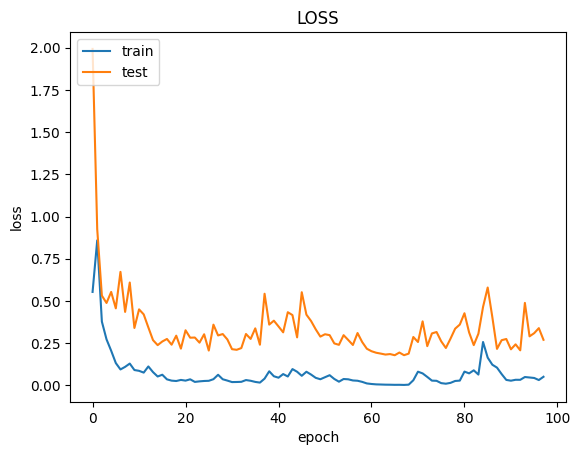

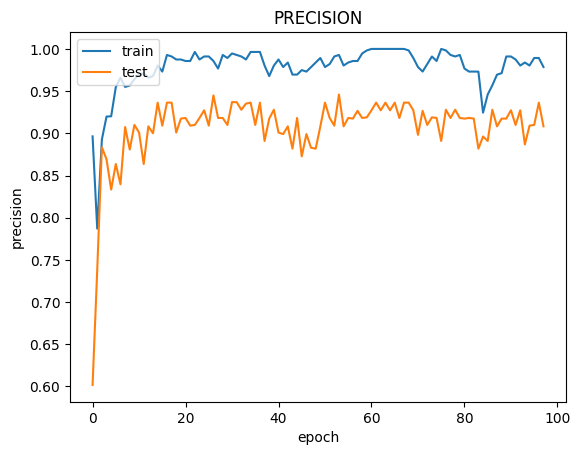

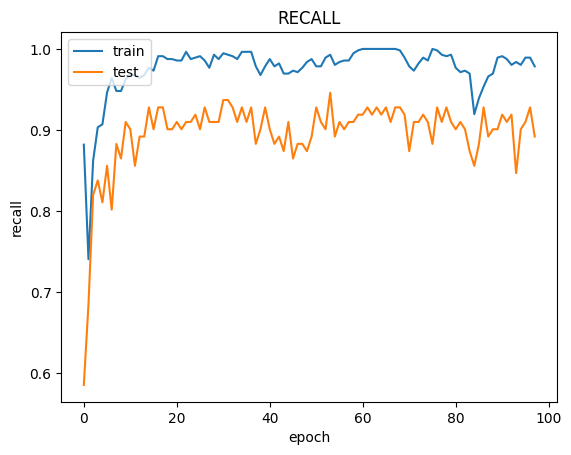

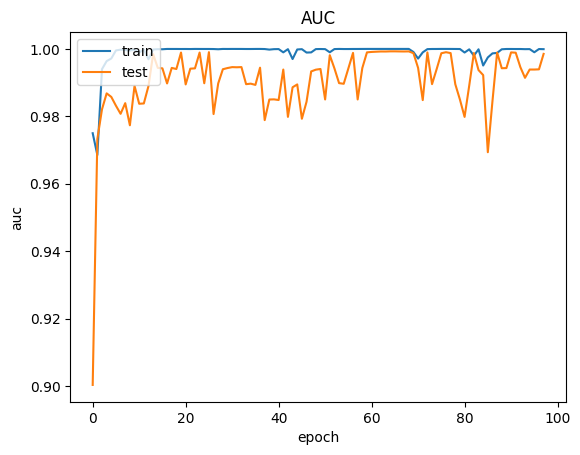

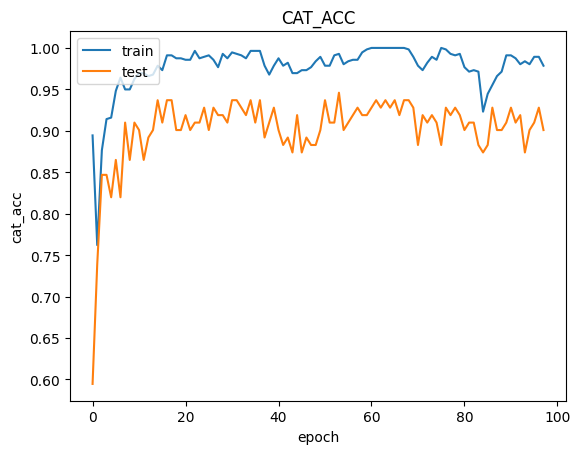

In [14]:
plot_metrics_history(metrics_results[4]['history'])

Un desviación estándar (std) de 0.03 en el resultado de la función cross_validate indica que los resultados de la métrica de evaluación utilizada tienen una variabilidad relativamente baja entre las diferentes divisiones de entrenamiento y prueba durante la validación cruzada.

Esto indica qué tan dispersos están los valores con respecto a la media. En el contexto de la validación cruzada, una desviación estándar baja indica que los resultados de la métrica de evaluación (por ejemplo, precisión, exactitud, puntaje F1, etc.) son consistentes y similares en todas las divisiones de entrenamiento y prueba. Por lo tanto este valor sugiere que el modelo tiene un rendimiento estable y robusto en diferentes conjuntos de datos de entrenamiento y prueba. Esto es deseable, ya que indica que el modelo es menos sensible a la variación en los datos de prueba y es más confiable en términos de su rendimiento general.

## Métricas de test - modelo base

In [15]:
%%time
# Entrenamiento de modelo base y evaluacion con datos de test
test_LSTM, test_dicc_LSTM= metrics(y_test, X_test, base_model_LSTM)
test_LSTM

CPU times: total: 2.12 s
Wall time: 6.44 s


,metrica,valor
0,precision,0.94
1,recall,0.93
2,f1,0.93
3,f05,0.94
4,f2,0.93
5,accuracy,0.93


## Evaluacion de métricas test

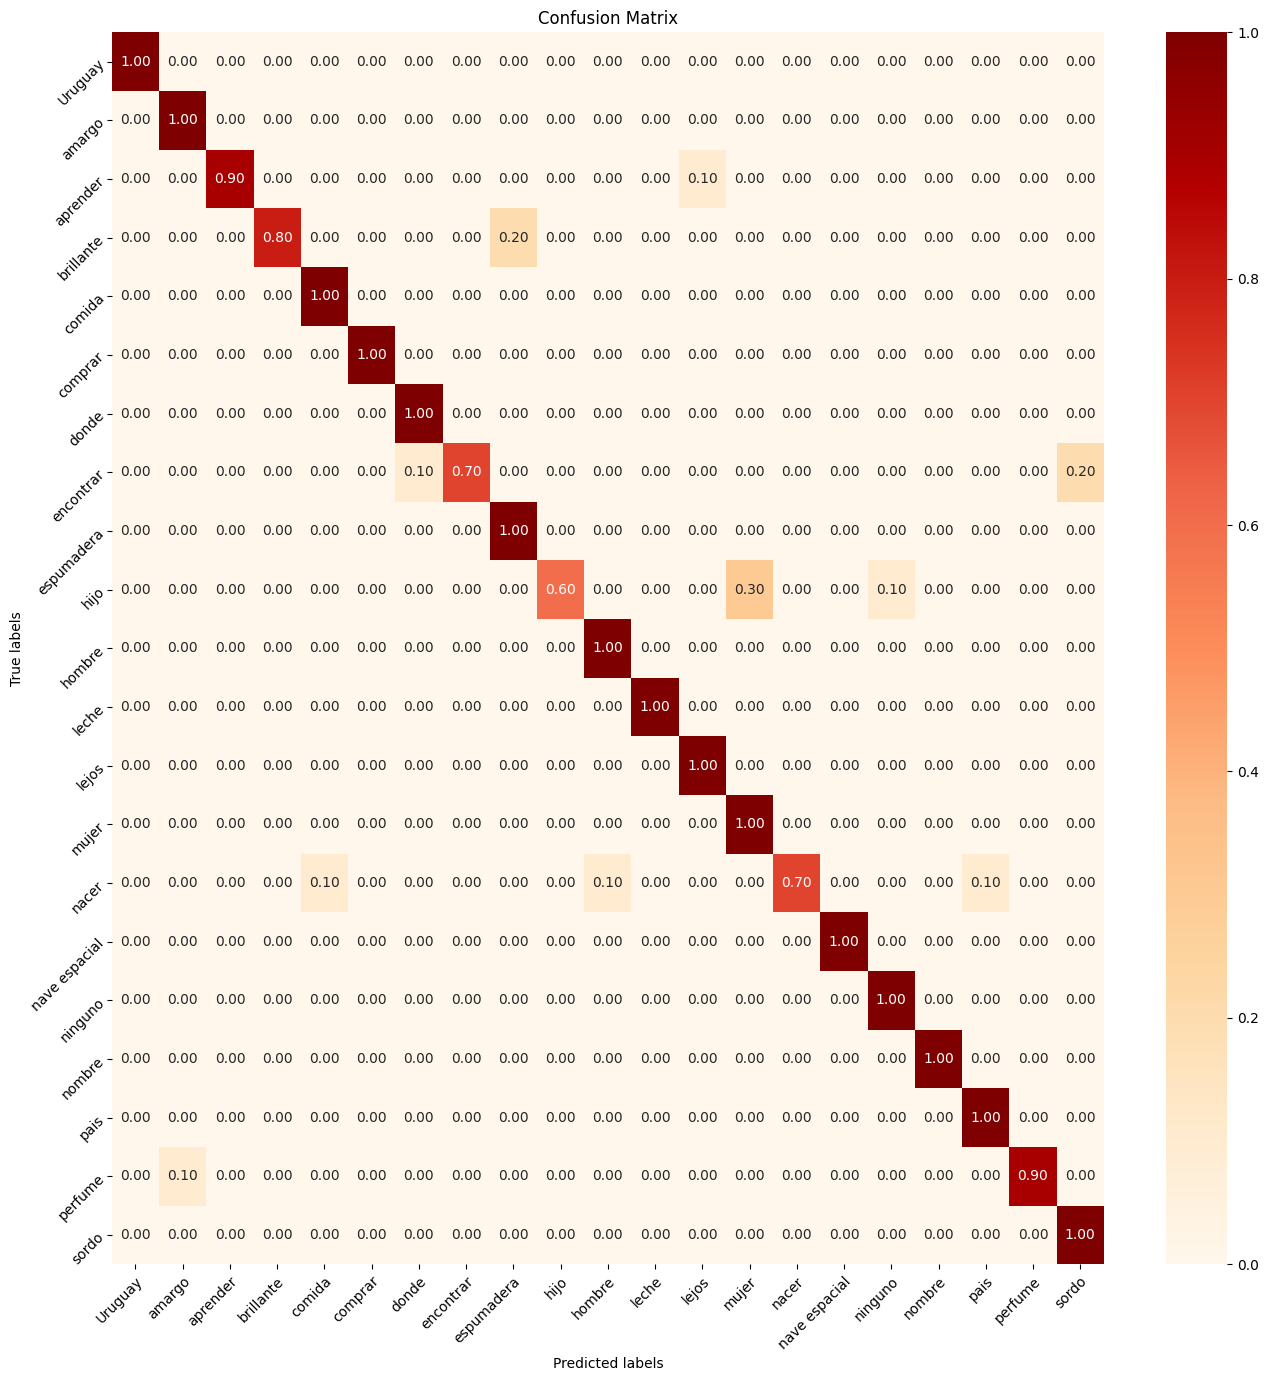

In [16]:
plot_matrix_confusion(X_test, y_test, le, base_model_LSTM)

In [17]:
y_pred = [np.argmax(i) for i in base_model_LSTM.predict(X_test)]
reporting_table(y_test,y_pred,le)

C:\Users\facur\AppData\Local\Temp\ipykernel_9448\878463940.py:133: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2)


,precision,recall,f1-score,support
Uruguay,1.00,1.00,1.00,10.00
amargo,0.91,1.00,0.95,10.00
aprender,1.00,0.90,0.95,10.00
brillante,1.00,0.80,0.89,10.00
comida,0.91,1.00,0.95,10.00
comprar,1.00,1.00,1.00,10.00
donde,0.91,1.00,0.95,10.00
encontrar,1.00,0.70,0.82,10.00
espumadera,0.83,1.00,0.91,10.00
hijo,1.00,0.60,0.75,10.00


>Precision

La precisión representa la proporción de instancias clasificadas como positivas que son realmente positivas. Por ejemplo, si la precisión para la clase "Uruguay" es 0.77, significa que el 77% de las instancias clasificadas como "Uruguay" son realmente "Uruguay". Una precisión alta indica que el modelo tiene una baja tasa de falsos positivos.

>Recall

El recall representa la proporción de instancias positivas que fueron correctamente identificadas por el modelo. Por ejemplo, si el recall para la clase "Uruguay" es 1, significa que el modelo identificó correctamente todas las instancias de la clase "Uruguay". Un recall alto indica que el modelo tiene una baja tasa de falsos negativos.

>F1-score

El F1-score es una medida combinada de precision y recall que proporciona una medida única del rendimiento del modelo. Es la media armónica de precision y recall. Un F1-score más alto indica un mejor equilibrio entre precision y recall, lo que implica un mejor rendimiento del modelo en general.

>Support

El support es el número de instancias en cada clase. En tu caso, parece que cada clase tiene un total de 10 instancias. Esta información es útil para comprender la distribución de las clases y el tamaño de cada una.

> Accuracy

La exactitud representa la proporción de instancias clasificadas correctamente sobre el total de instancias. Por ejemplo, si la exactitud es del 88%, significa que el modelo clasificó correctamente el 88% de las instancias. Una alta exactitud indica que el modelo está realizando buenas predicciones en general.

> Macro Avg

El macro avg es el promedio no ponderado de las métricas (precision, recall, F1-score) para todas las clases. Proporciona una medida general del rendimiento del modelo sin tener en cuenta el desequilibrio de clases. Un macro avg alto indica un buen rendimiento promedio en todas las clases.

>Weighted Avg

El weighted avg es el promedio ponderado de las métricas (precision, recall, F1-score) para todas las clases, donde el peso es proporcional al número de instancias en cada clase. Toma en cuenta el desequilibrio de clases al calcular la medida general del rendimiento del modelo. Un weighted avg alto indica un buen rendimiento general del modelo considerando el tamaño y la distribución de las clases.






# Optimización

In [18]:
# %%time
if OPTIMIZAR:
    param_grid = {
        'neurons_input': [64, 128, 256],
        'activation': ['tanh'], #dejo tanh para el uso de la gpu
        'learning_rate': [0.001, 0.01],
    }

    opt_model_1 = build_model_for_optimization(param_grid['neurons_input'][0], 'tanh', param_grid['learning_rate'][0])
    history_1 = opt_model_1.fit(X_train, to_one_hot_encoding(y_train), epochs=200, callbacks=esLoss, validation_data=(X_test, to_one_hot_encoding(y_test)))

    opt_model_2 = build_model_for_optimization(param_grid['neurons_input'][1], 'tanh', param_grid['learning_rate'][1])
    history_2 = opt_model_2.fit(X_train, to_one_hot_encoding(y_train), epochs=200, callbacks=esLoss, validation_data=(X_test, to_one_hot_encoding(y_test)))

    opt_model_3 = build_model_for_optimization(param_grid['neurons_input'][2], 'tanh', param_grid['learning_rate'][0])
    history_3 = opt_model_3.fit(X_train, to_one_hot_encoding(y_train), epochs=200, callbacks=esLoss, validation_data=(X_test, to_one_hot_encoding(y_test)))

    opt_model_4 = build_model_for_optimization(param_grid['neurons_input'][0], 'tanh', param_grid['learning_rate'][1])
    history_4 = opt_model_4.fit(X_train, to_one_hot_encoding(y_train), epochs=200, callbacks=esLoss, validation_data=(X_test, to_one_hot_encoding(y_test)))
    
    opt_model_5 = build_model_for_optimization(param_grid['neurons_input'][1], 'tanh', param_grid['learning_rate'][0])
    history_5 = opt_model_5.fit(X_train, to_one_hot_encoding(y_train), epochs=200, callbacks=esLoss, validation_data=(X_test, to_one_hot_encoding(y_test)))
    
    opt_model_6 = build_model_for_optimization(param_grid['neurons_input'][2], 'tanh', param_grid['learning_rate'][1])
    history_6 = opt_model_6.fit(X_train, to_one_hot_encoding(y_train), epochs=200, callbacks=esLoss, validation_data=(X_test, to_one_hot_encoding(y_test)))

    # Imprimir los mejores hiperparámetros encontrados
    print("Mejores hiperparámetros encontrados:")

Epoch 1/200
21/21 [==============================] - 7s 226ms/step - loss: 3.0710 - precision: 0.9083 - recall: 0.2640 - auc: 0.7466 - cat_acc: 0.3192 - val_loss: 2.8917 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6709 - val_cat_acc: 0.1238
Epoch 2/200
21/21 [==============================] - 0s 20ms/step - loss: 2.8279 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7020 - cat_acc: 0.1312 - val_loss: 2.5963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7900 - val_cat_acc: 0.1619
Epoch 3/200
21/21 [==============================] - 0s 21ms/step - loss: 2.5155 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8135 - cat_acc: 0.1700 - val_loss: 2.3604 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8447 - val_cat_acc: 0.2952
Epoch 4/200
21/21 [==============================] - 0s 20ms/step - loss: 2.2179 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8817 - cat_acc: 0.3234 - val_loss: 2.0604 - val_precision: 0.0

In [19]:
test_opt_LSTM_1, _= metrics(y_test, X_test, opt_model_1)
print("\n-------Tabla 1")
print(test_opt_LSTM_1)

test_opt_LSTM_2, _= metrics(y_test, X_test, opt_model_2)
print("\n-------Tabla 2")
print(test_opt_LSTM_2)

test_opt_LSTM_3, _= metrics(y_test, X_test, opt_model_3)
print("\n-------Tabla 3")
print(test_opt_LSTM_3)

test_opt_LSTM_4, _= metrics(y_test, X_test, opt_model_4)
print("\n-------Tabla 4")
print(test_opt_LSTM_4)

test_opt_LSTM_5, _= metrics(y_test, X_test, opt_model_5)
print("\n-------Tabla 5")
print(test_opt_LSTM_5)

test_opt_LSTM_6, _= metrics(y_test, X_test, opt_model_6)
print("\n-------Tabla 6")
print(test_opt_LSTM_6)


-------Tabla 1
     metrica  valor
0  precision   0.95
1     recall   0.95
2         f1   0.95
3        f05   0.95
4         f2   0.95
5   accuracy   0.95


c:\Users\facur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



-------Tabla 2
     metrica  valor
0  precision   0.03
1     recall   0.06
2         f1   0.02
3        f05   0.02
4         f2   0.02
5   accuracy   0.06

-------Tabla 3
     metrica  valor
0  precision   0.92
1     recall   0.92
2         f1   0.92
3        f05   0.92
4         f2   0.92
5   accuracy   0.92

-------Tabla 4
     metrica  valor
0  precision   0.82
1     recall   0.80
2         f1   0.79
3        f05   0.81
4         f2   0.79
5   accuracy   0.80

-------Tabla 5
     metrica  valor
0  precision   0.95
1     recall   0.94
2         f1   0.94
3        f05   0.95
4         f2   0.94
5   accuracy   0.94

-------Tabla 6
     metrica  valor
0  precision   0.00
1     recall   0.05
2         f1   0.00
3        f05   0.00
4         f2   0.01
5   accuracy   0.05


c:\Users\facur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> learning_rate

Tasa de aprendizaje que controla la contribución de cada árbol. Un valor más bajo puede hacer que el modelo sea más preciso, pero también puede requerir más árboles y tiempo de entrenamiento.

> n_estimators

Número de árboles en el modelo. Un valor más alto puede mejorar el rendimiento, pero también aumentará el tiempo de entrenamiento.

> max_depth

Profundidad máxima de cada árbol. Controla la complejidad del modelo. Un valor más alto puede capturar relaciones más complejas, pero también puede provocar sobreajuste.

> min_child_weight

Peso mínimo necesario para crear un nuevo nodo en el árbol. Controla la regularización y ayuda a evitar divisiones insignificantes. Un valor más alto puede evitar sobreajuste.

> subsample

Proporción de muestras utilizadas para entrenar cada árbol. Un valor menor reduce la varianza y puede evitar el sobreajuste.

> colsample_bytree

Proporción de características utilizadas para entrenar cada árbol. Un valor menor reduce la varianza y puede evitar el sobreajuste.

> reg_alpha

Término de regularización L1 (Lasso) aplicado a los pesos de los nodos del árbol. Un valor más alto impone una mayor regularización.

> reg_lambda

Término de regularización L2 (Ridge) aplicado a los pesos de los nodos del árbol. Un valor más alto impone una mayor regularización.

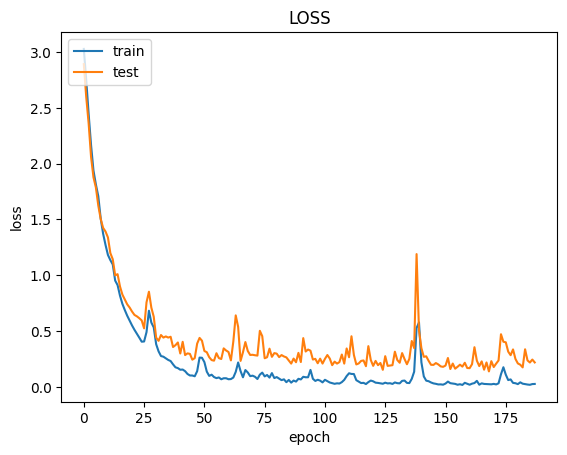

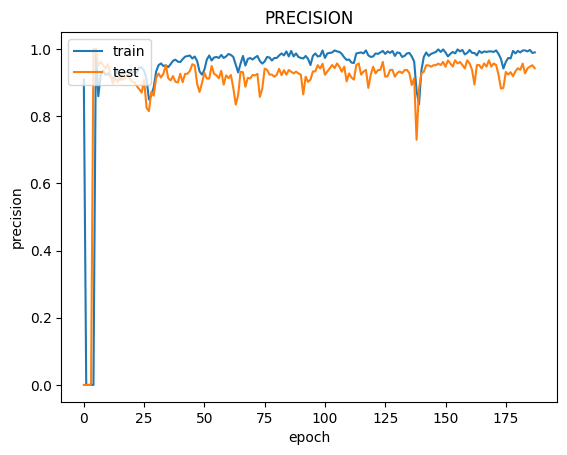

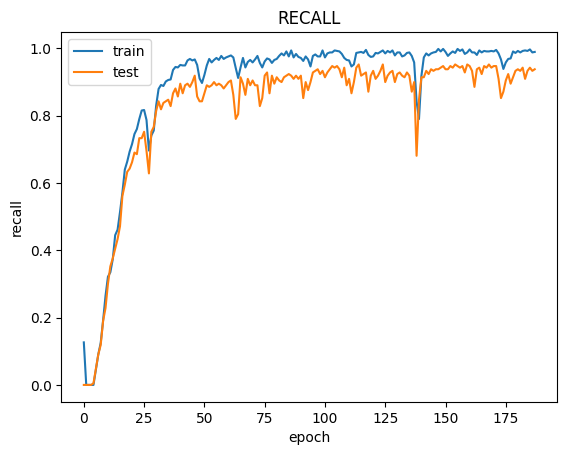

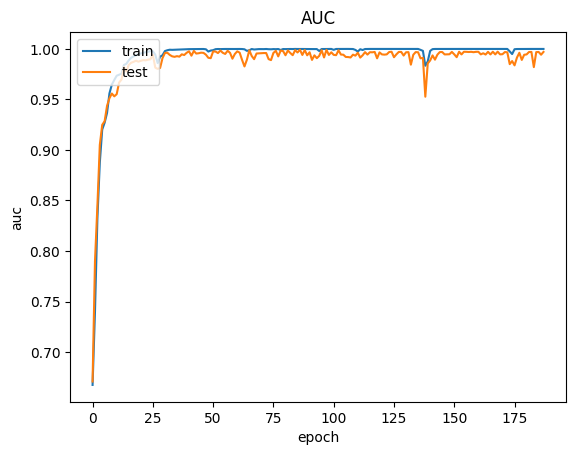

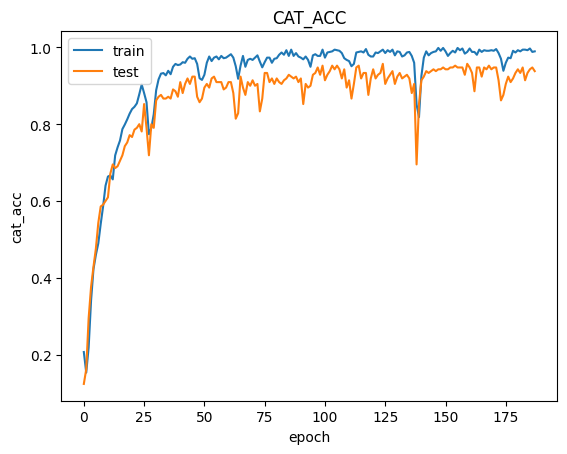

In [20]:
# colocar history_X correspondiente a graficar
plot_metrics_history(history_1)

## Probamos mejores hiperparametros

In [30]:
# Los parametros enviados a build_model_for_optimization(), son los que llevaron al mejor valor en las tablas de la celda anterior
model_LSTM_opt = build_model_for_optimization(param_grid['neurons_input'][0], 'tanh', param_grid['learning_rate'][0])
one_hot_encoded_y = to_one_hot_encoding(y_train)
model_LSTM_opt.fit(X_train, 
                   one_hot_encoded_y,
                   epochs = 300,
                   callbacks=esLoss)

Epoch 1/300
21/21 [==============================] - 3s 18ms/step - loss: 3.1188 - precision: 1.0000 - recall: 0.6731 - auc: 0.9372 - cat_acc: 0.6917
Epoch 2/300
21/21 [==============================] - 0s 14ms/step - loss: 2.9692 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6026 - cat_acc: 0.0861
Epoch 3/300
21/21 [==============================] - 0s 14ms/step - loss: 2.7661 - precision: 0.7939 - recall: 0.0058 - auc: 0.7284 - cat_acc: 0.1210
Epoch 4/300
21/21 [==============================] - 0s 14ms/step - loss: 2.4451 - precision: 0.8416 - recall: 0.0121 - auc: 0.8299 - cat_acc: 0.2355
Epoch 5/300
21/21 [==============================] - 0s 14ms/step - loss: 2.1673 - precision: 0.8880 - recall: 0.0126 - auc: 0.8841 - cat_acc: 0.3177
Epoch 6/300
21/21 [==============================] - 0s 15ms/step - loss: 2.0035 - precision: 0.9061 - recall: 0.0158 - auc: 0.9090 - cat_acc: 0.3745
Epoch 7/300
21/21 [==============================] - 0s 14ms/step - loss: 1.8805 - precision

In [31]:
test_lstm_opt, _= metrics(y_test, X_test, model_LSTM_opt)
test_lstm_opt

,metrica,valor
0,precision,0.95
1,recall,0.94
2,f1,0.94
3,f05,0.95
4,f2,0.94
5,accuracy,0.94


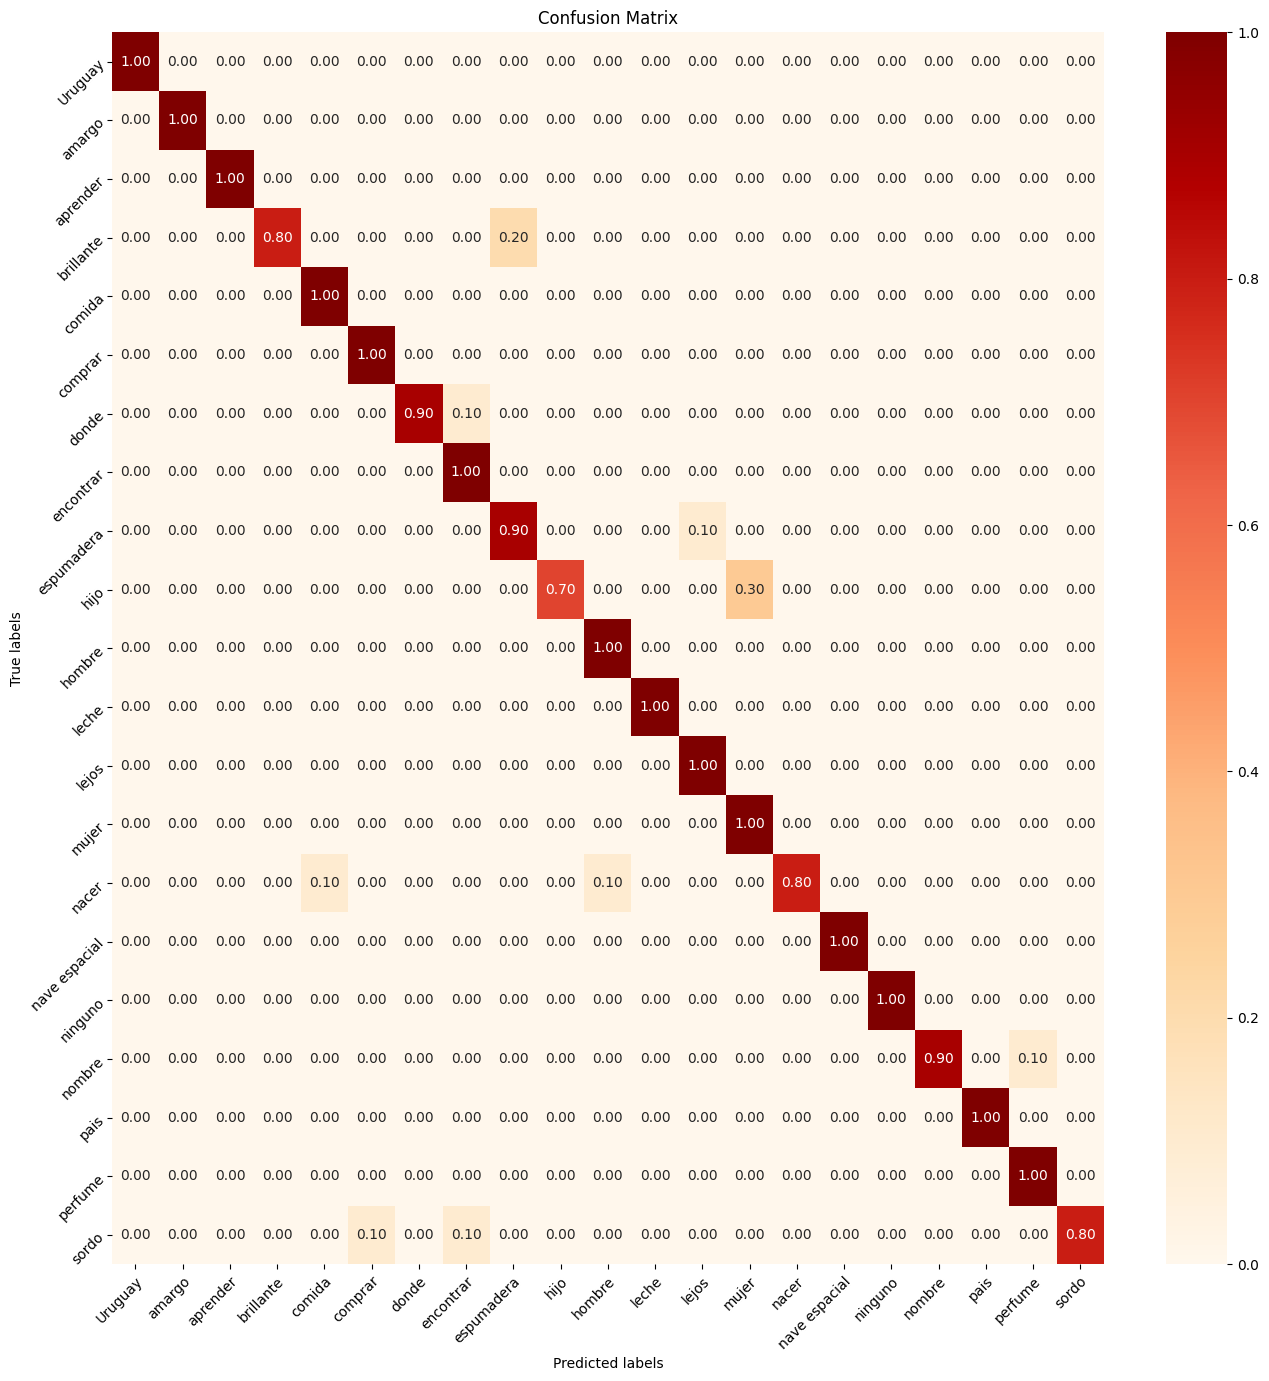

In [32]:
plot_matrix_confusion(X_test, y_test, le, model_LSTM_opt)

In [33]:
y_pred = [np.argmax(i) for i in model_LSTM_opt.predict(X_test)]
reporting_table(y_test,y_pred,le)

C:\Users\facur\AppData\Local\Temp\ipykernel_9448\878463940.py:133: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2)


,precision,recall,f1-score,support
Uruguay,1.00,1.00,1.00,10.00
amargo,1.00,1.00,1.00,10.00
aprender,1.00,1.00,1.00,10.00
brillante,1.00,0.80,0.89,10.00
comida,0.91,1.00,0.95,10.00
comprar,0.91,1.00,0.95,10.00
donde,1.00,0.90,0.95,10.00
encontrar,0.83,1.00,0.91,10.00
espumadera,0.82,0.90,0.86,10.00
hijo,1.00,0.70,0.82,10.00


# Modelo final prueba con partición de validación

In [34]:
test_lstm_opt, _= metrics(y_valid, X_valid, model_LSTM_opt)
test_lstm_opt

,metrica,valor
0,precision,0.96
1,recall,0.96
2,f1,0.96
3,f05,0.96
4,f2,0.96
5,accuracy,0.96


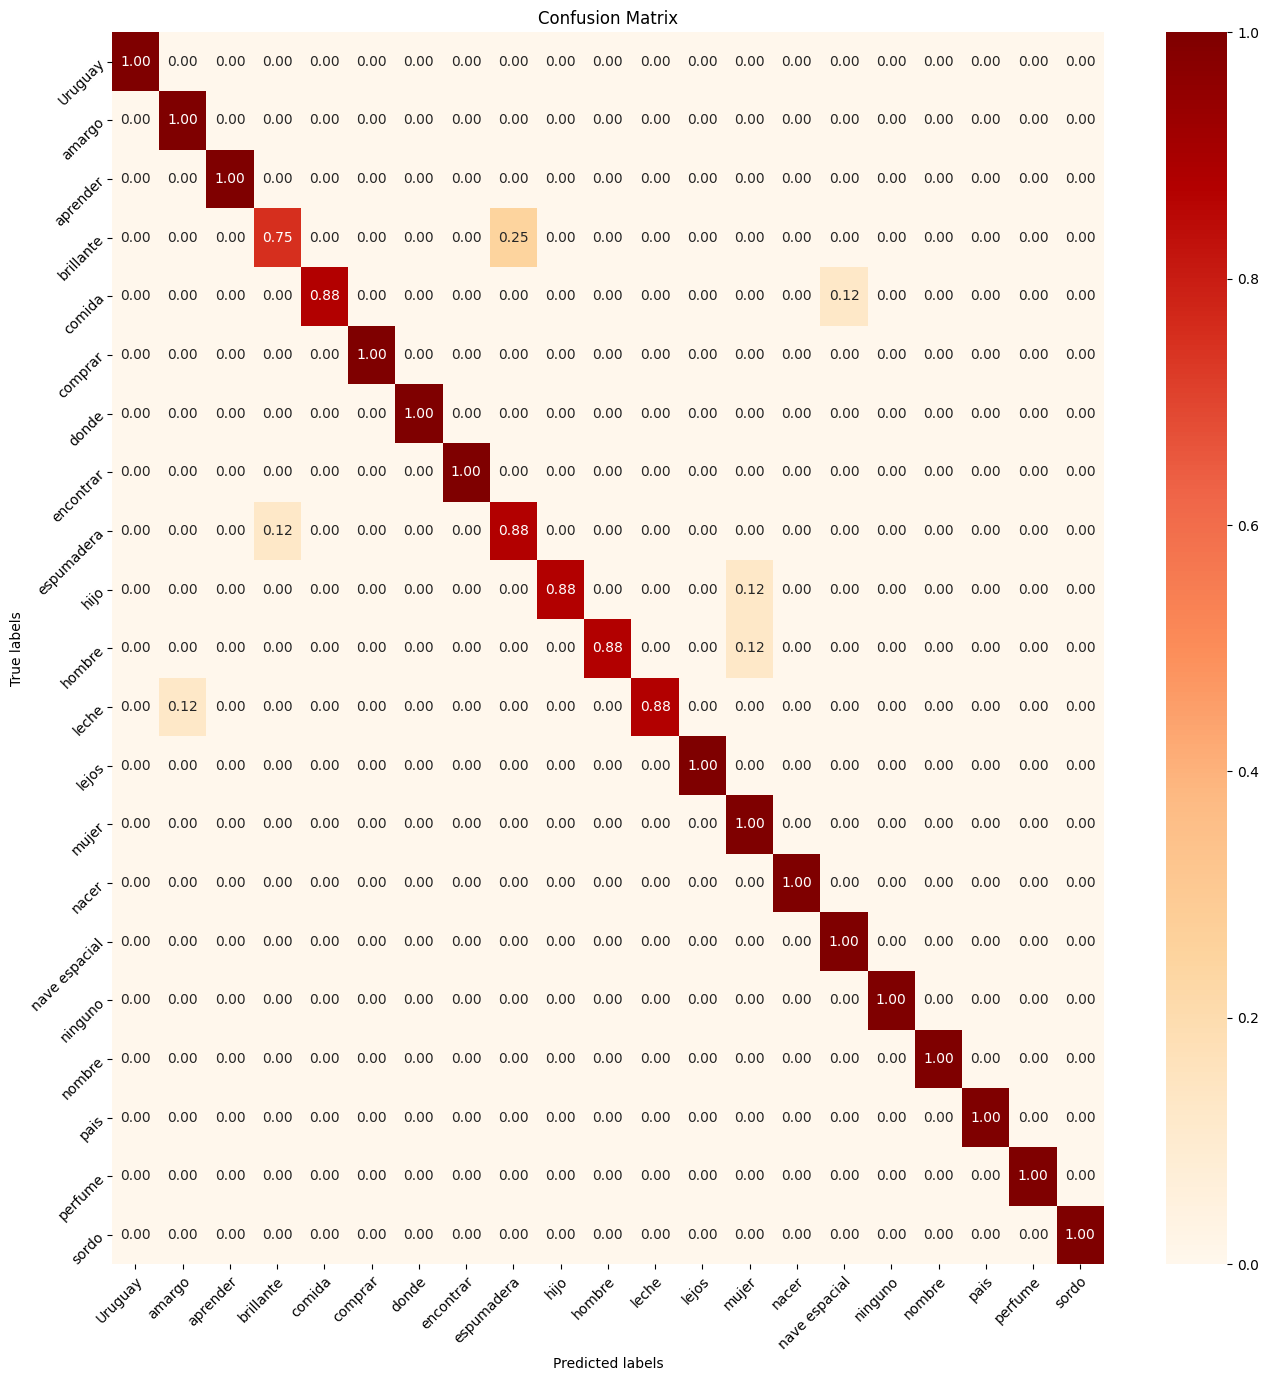

In [35]:
plot_matrix_confusion(X_valid, y_valid, le, model_LSTM_opt)

In [36]:
y_pred = [np.argmax(i) for i in model_LSTM_opt.predict(X_valid)]
reporting_table(y_valid,y_pred,le)

C:\Users\facur\AppData\Local\Temp\ipykernel_9448\878463940.py:133: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2)


,precision,recall,f1-score,support
Uruguay,1.00,1.00,1.00,8.00
amargo,0.89,1.00,0.94,8.00
aprender,1.00,1.00,1.00,8.00
brillante,0.86,0.75,0.80,8.00
comida,1.00,0.88,0.93,8.00
comprar,1.00,1.00,1.00,8.00
donde,1.00,1.00,1.00,8.00
encontrar,1.00,1.00,1.00,8.00
espumadera,0.78,0.88,0.82,8.00
hijo,1.00,0.88,0.93,8.00


# Guarado de modelo

In [37]:
import os
os.getcwd()

'c:\\Users\\facur\\Desktop\\tesis_LSA\\codigos_datos_tesis\\Notebooks\\Lengua_Seña_CLF\\02_modelado\\GRU'

In [38]:
# Guardar modelo en joblib

#joblib.dump(modelxgb_base,'/00_modelos/03_xgboost_criterio_random_base.joblib')
joblib.dump(modelxgb_opt,'00_modelos/03_xgboost_criterio_poda_30fr_with_face.joblib')

NameError: name 'modelxgb_opt' is not defined